In [1]:
import nltk
import glob, os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
import string
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
from nltk.text import Text
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
pd. set_option('display.max_rows', None)

In [2]:
path = 'data/articles'
os.chdir(path)

In [3]:
tokenizer = RegexpTokenizer(r'\w+')
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

def remove_whitespace(text):
    return  " ".join(text.split())

def lemmatization(text): 
    result=[]
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))
    
    return result

def stemming(text):
    porter = PorterStemmer()
    result=[]
    for word in text:
        result.append(porter.stem(word))
    return result

In [4]:
#preprocessing with tokenizer
def tok_prepro_docs(docs, nouns=False, stemlem=False):
    newd = []
    newd_sw = []
    for i in docs:
        i = i.lower()
        i = remove_whitespace(i)
        date = re.findall(r'(\d+/\d+/\d+)', i)
        date2 = re.findall(r'(\d+\s(?:jan|feb|mar|apr|may|jun|jul|aug|oct|sep|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december|January|February|March|April|May|June|July|August|September|October|November|December)\s\d+)',
                           i)
        dates = (date + date2)
        for x in dates:
            i = i.replace(x, '')
        i = i.translate(str.maketrans('', '', string.punctuation)) 
        i = i.replace('ÿ', '')
        i = tokenizer.tokenize(i)
        if nouns:
            tags = nltk.pos_tag(i)
            nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
           # i = spell_check(i)
            newd_sw.append(nouns)
            newi = [w for w in nouns if not w.lower() in stop_words]
        else:
            newd_sw.append(i)
            newi = [w for w in i if not w.lower() in stop_words]
        if stemlem:
            newi = lemmatization(newi)
            newi = stemming(newi)
        newd.append(newi)
    return newd

def no_tok_prepro_docs(docs):
    texts = []
    newd_sw = []
    for i in docs:
        i = i.lower()
        i = remove_whitespace(i)
        date = re.findall(r'(\d+/\d+/\d+)', i)
        date2 = re.findall(r'(\d+\s(?:jan|feb|mar|apr|may|jun|jul|aug|oct|sep|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december|January|February|March|April|May|June|July|August|September|October|November|December)\s\d+)',
                           i)
        dates = (date + date2)
        for x in dates:
            i = i.replace(x, '')
        texts.append(i)
    return texts

In [5]:
def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  fig, ax = plt.subplots(figsize=(50,50))
  sns.heatmap(df, cmap=cmap)

def sorted_alphanumeric(path):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(path, key=alphanum_key)

def create_tsne():
    """
    This function will performs the TSNE dimensionality reduction on the articles, historical documents, resumes.
    """
    ordered_dir = sorted_alphanumeric(os.listdir())
    documents = [open(f).read() for f in ordered_dir]
    tfidf = TfidfVectorizer().fit_transform(documents)
    pca = PCA(n_components=2)
    df = pca.fit_transform(tfidf.todense())
    return df

def plot_tsne_kmeans(k, df):
    """
    This function will take the pca's as input and convert it to a k-means plot
    k  -> number of means (clusters)
    df -> dataframe containing pca values 
    """
    kmeans = KMeans(n_clusters= k)
    label = kmeans.fit_predict(df)
    dff = pd.DataFrame(df, columns=['tsne1', 'tsne2'])
    dff['label'] = [str(i) for i in label]
    dff['label2']= label
    dff['article'] = [i for i in range(845)]
    df = dff.sort_values(by='label2')
    df = df[['tsne1', 'tsne2', 'label', 'article']]
    return px.scatter(df, x='tsne1', y='tsne2', color="label", hover_data=['article']), df
 
def make_bar(docs, size=20, flatten=True):
    if flatten:
        freq = nltk.FreqDist(make_flat(docs))
    else:
        freq = nltk.FreqDist(docs)
    testcloud = freq.most_common(size)
    freqdf = pd.DataFrame(testcloud, columns=['Word', 'Frequency'])
    sns.set(rc={'figure.figsize':(16,11)})
    sns.barplot(x='Frequency',y='Word', data=freqdf)

def make_wc(docs, size=20, flatten=True):
    if flatten:
        freq = nltk.FreqDist(make_flat(docs))
    else:
        freq = nltk.FreqDist(docs)
    testcloud = freq.most_common(size)
    freqdf = pd.DataFrame(testcloud, columns=['Word', 'Frequency'])
    dataa = freqdf.set_index('Word').to_dict()['Frequency']
    wc = WordCloud(background_color='white', width=800, height=400, max_words=200).generate_from_frequencies(dataa)
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def make_flat(docs):
    doclist = tok_prepro_docs(docs)
    
    flat_list = [item for sublist in doclist for item in sublist]
    
    return flat_list

In [6]:
ordered_dir = sorted_alphanumeric(os.listdir())
documents = [open(f).read() for f in ordered_dir]

In [34]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

tfdoc = tfidf.fit_transform(tok_prepro_docs(documents, stemlem=True))

# tsne = TSNEVisualizer()
# tsne.fit(tfdoc)
# tsne.show()

# clusters = KMeans(n_clusters=5)
# clusters.fit(tfdoc)

# tsne = TSNEVisualizer()
# tsne.fit(tfdoc, ["c{}".format(c) for c in clusters.labels_])
# tsne.poof()

# fn = tfidf.get_feature_names()

In [35]:
#shows the 5 most related articles with article 0
# from sklearn.metrics.pairwise import linear_kernel
# cosine_similarities = linear_kernel(tfdoc[0:1], tfdoc).flatten()


# related_docs_indices = cosine_similarities.argsort()[:-5:-1]
# related_docs_indices

array([  0,  33, 520, 753], dtype=int64)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold

X = cosine_similarity(tfdoc, tfdoc)
model = manifold.TSNE(random_state=1, metric="precomputed")
Y = model.fit_transform(X) 

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, metric="cosine")

embs = tsne.fit_transform(tfdoc)

In [59]:
df = pd.DataFrame()
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

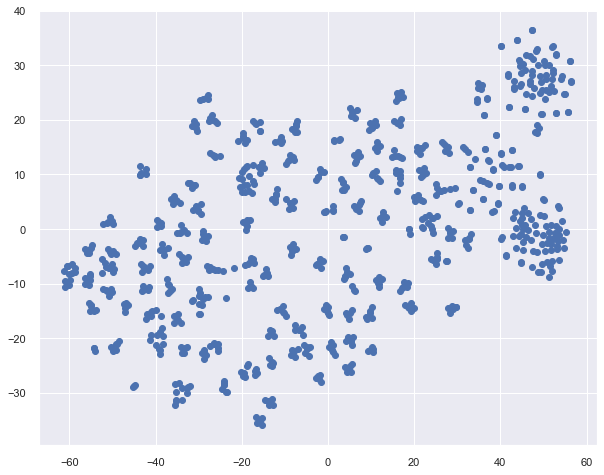

In [60]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y)

In [89]:
df2 = df[df['x'].between(40, 60)]
df2 = df2[df2['y'].between(-10, 5)]
# df2.sort_values(['x', 'y'], ascending=[True, True])

In [90]:
df2

,x,y
9,52.257633,-1.749918
11,43.571239,0.226663
26,49.270359,2.497927
31,51.288708,-0.562868
32,44.818840,-0.910586
39,52.046730,-5.813455
44,45.738594,0.692106
70,53.593853,0.002153
76,44.742558,-5.978966
85,51.760891,-2.837107


In [91]:
ilist = df2.index.values.tolist()

In [92]:
filtered_docs = []

for i in ilist:
    filtered_docs.append(documents[i])

In [93]:
filtered_prepro = no_tok_prepro_docs(filtered_docs)

In [94]:
# import nltk

# from nltk import ne_chunk, pos_tag, word_tokenize
# from nltk.tree import Tree

# names = []
# for i in filtered_docs:
#     nltk_results = ne_chunk(pos_tag(word_tokenize(i)))
#     for nltk_result in nltk_results:
#         if type(nltk_result) == Tree:
#             name = ''
#             for nltk_result_leaf in nltk_result.leaves():
#                 name += nltk_result_leaf[0] + ' '
#             names.append(name)

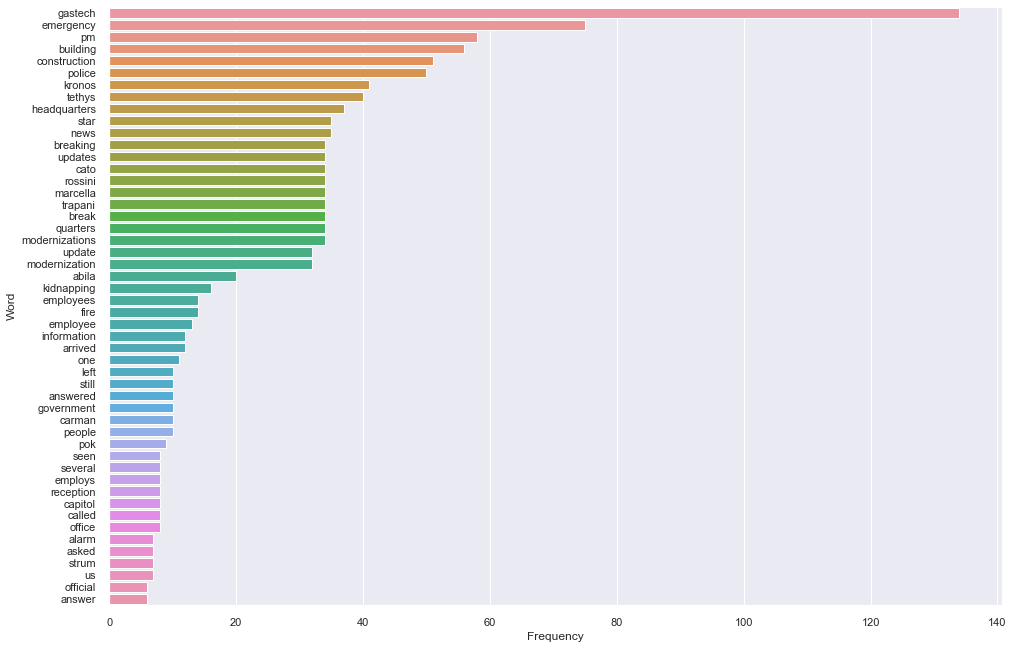

In [95]:
make_bar(filtered_prepro, size=50, flatten=True)